In [11]:
import torch
import torchvision
# 将数据集合下载到指定的目录下
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False
)
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False
)


print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
# 定义映像文件的保存位置（需要首先建立 pt 目录）

train_test_ptFile = './pt/train_test_of_MINST.pt'

# 保存映像内容到文件,注意torch.save只能保存一个对象，因此采用元组封装两个数据集

torch.save((train_dataset, test_dataset), train_test_ptFile)

当映像文件保存完成后，将来可以直接从存储介质上读取。代码如下：

In [13]:
train_dataset, test_dataset = torch.load(train_test_ptFile)
print(len(train_dataset), len(test_dataset))

60000 10000


In [3]:
import numpy as np
import matplotlib.pyplot as plt 

features,label = train_dataset[0]
print(f'数据特征（图片）的维度信息是:{features.shape},标记值是：{label}')


数据特征（图片）的维度信息是:torch.Size([1, 28, 28]),标记值是：5


In [ ]:
# 原始数据是归一化后的数据,  因此这里需要反归一化

img = features.view(28,28)
img = np.array(img) * 255
plt.imshow(img,"gray")
plt.show()


In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True
)
for features,label in train_loader:   # features和label就是X和Y
    print(features.shape)
    print(label.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [7]:
import numpy as np


def softmax(x):  # 思考一下，为何使用np.exp(x)???
    return np.exp(x) / np.sum(np.exp(x))


# 测试softmax
x = np.array([2.0, 1.0, 0.1])
outputs = softmax(x)

print("numpy版softmax的输入：", x)
print("numpy版softmax的输出：", outputs)
print("numpy版softmax的输出之和：", outputs.sum())


numpy版softmax的输入： [2.  1.  0.1]
numpy版softmax的输出： [0.65900114 0.24243297 0.09856589]
numpy版softmax的输出之和： 1.0


In [8]:
import torch

x = torch.tensor([2.0, 1.0, 0.1])
outputs = torch.softmax(x, dim=0)

print("torch版 softmax的输入：", x)
print("torch版 softmax的输出：", outputs)
print("torch版 softmax的输出之和：", outputs.sum())


torch版 softmax的输入： tensor([2.0000, 1.0000, 0.1000])
torch版 softmax的输出： tensor([0.6590, 0.2424, 0.0986])
torch版 softmax的输出之和： tensor(1.0000)


### 3.2.6 多层神经网络的建立 完整代码

In [16]:
import torch
import torchvision

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#确认pt目录已存在，前述保存工作已经完成
train_test_ptFile = './pt/train_test_of_MINST.pt'
train_dataset, test_dataset = torch.load(train_test_ptFile)

#数据加载器，加载数据集
train_dataloader = torch.utils.data.DataLoader(
    dataset= train_dataset,
    batch_size = 100,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size=100,
    shuffle=True
)


In [17]:
#神经网络类定义
class HR_Model(torch.nn.Module):
    def __init__(self,in_features, hidden_size, out_classes) -> None:
        super().__init__()
        # 1.线性层
        self.linear1 = torch.nn.Linear(in_features, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size,out_classes)
        # 2.激活函数
        self.relu = torch.nn.ReLU()
        # 3.激活函数层
        self.softmax = torch.nn.Softmax(dim=1)  #第0维是批次，第1维是数据（或者说，行与列-->按列softmax）

    def forward(self, x):   #注意这里hi小写x
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.softmax(out)
        return out   # forward是计算图函数


In [19]:
#建立神经网络模型，图片是28*28像素，隐层宽度是500
#分类数量是10（0-9个手写数字）
# device用于设定使用 cpu 或 gpu
hidden_size = 500

model = HR_Model(28 * 28, hidden_size, 10).to(device)

lossFun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
import datetime
starttime = datetime.datetime.now()

for epoch in range(2):
    for i,(features,labels) in enumerate(train_dataloader):
        #装载到内存或GPU中 device = 'cpu' or 'gpu'
        features = features.view(-1,28*28).to(device)
        labels = labels.to(device)

        # 1. 正向传播
        pred = model(features)  # 调用model的forward()方法
        # 2. 计算损失
        loss = lossFun(pred, labels)
        # 3. 反向传播
        loss.backward()
        # 4. 更新参数
        optimizer.step()
        # 5. 清空梯度
        optimizer.zero_grad()
        if i % 100 == 0:
            print(f"loss={loss:.4f}")

end_time = datetime.datetime.now()
elapsedTime = (end_time - starttime).seconds
print(f"训练完成，耗时 {elapsedTime} 秒!")

loss=2.3023
loss=1.5676
loss=1.5899
loss=1.5909
loss=1.6122
loss=1.6182
loss=1.5607
loss=1.6211
loss=1.5984
loss=1.5852
loss=1.5321
loss=1.5984
训练完成，耗时 18 秒!


上图中的运行环境：win11，GPU是RTX2060S，CPU 9700K，内存32G。

训练完成后，下面我们从测试集中选几张图片来验证一下。

tensor([0, 2, 2, 4, 7])


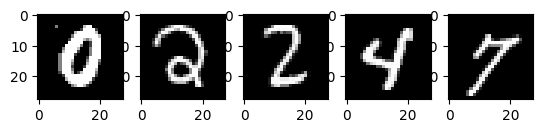

In [22]:
# 从测试集中取几条测试数据
samples = iter(test_dataloader)
features, labels = samples.__next__()  # samples.next()

# 显示前3条数据
import matplotlib.pyplot as plt
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(features[i][0], cmap="gray")

print(labels[0:5])

In [23]:
#测试集中样本的标记如下：
print(labels[:5])

tensor([0, 2, 2, 4, 7])


下面用预测模型验证下，看看能否预测准确？

仍然使用上述features中的五张手写图片，进行预测，代码如下：


In [24]:
# 使用模型进行预测
features = features.view(-1, 28 * 28)
# 注意，数据在内存里，不是GPU中
model.cpu()
with torch.no_grad():
    pred = model(features)
print(pred[0:5].int())

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=torch.int32)


上述结果需要人为观察，可以通过代码得知是否准确预测，代码如下：

In [25]:
values, indexes = torch.max(pred[0:5], axis=1)
print("预测值：", indexes)
print("真实值：", labels[0:5])

预测值： tensor([0, 2, 2, 4, 7])
真实值： tensor([0, 2, 2, 4, 7])


是否需要将测试集中所有样本都进行预测，并根据其是否全部预测正确，来了解训练好的模型的性能如何？
确实，准确率是了解模型性能的一个非常重要的指标。代码如下：

In [27]:
model.cpu()
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for features,labels in test_dataloader:
        features = features.view(-1,28*28)
        pred = model(features)
        # 获取最大的角标，表示的就是哪个数字
        values, indexes = torch.max(pred, axis=1)
        # 统计正确的结果
        num_correct += (indexes==labels).sum().item()
        num_samples += len(labels)
    print("模型的准确率：", num_correct / num_samples)

模型的准确率： 0.9177


为了在下一小节中，对自己建立的数字图片进行识别，我们采用模型保存的方法，将模型中训练好的参数进行保存。如下代码所示：

In [31]:
# 保存模型
model_state_ptFile = './model/handwriting_recognized_model_states.pt'
torch.save(model.state_dict(), model_state_ptFile)

# 读取和装载模型参数
state_dict = torch.load(model_state_ptFile)
model = HR_Model(28 * 28, hidden_size, 10)
model.load_state_dict(state_dict=state_dict)  # 这个模型就可以用于预测了！

<All keys matched successfully>